In [1]:
#5.4.5
%matplotlib ipympl
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight

    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        noised_nu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)
        #self.pose = IdealRobot.state_transition(nu, omega, time, self.pose)
    
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):
        #print("obs")
        #print(observation)
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            #ランとマークの姿勢計算
            #print(obs_id)
            
            pos_on_map = envmap.landmarks[obs_id].pos
            
            #particle_suggest_pos = IdealCamera.relative_polar_pos(self.pose,pos_on_map)
            particle_suggest_pos = IdealCamera.observation_function(self.pose,pos_on_map)

            #尤度の計算
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *=multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)
            

In [3]:
class Mcl:
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.1, "no":0.001, "on":0.1, "oo":0.2},\
                 distance_dev_rate=0.14, direction_dev=0.05):
        self.particles = [Particle(init_pose, 1.0 / num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov = c)

    def motion_update(self, nu,omega, time):
        #print(self.motion_noise_rate_pdf.cov)
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
    #5.4.1
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev)
    
    def draw(self,ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) for p in self.particles]
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) for p in self.particles]
        elems.append(ax.quiver(xs,ys,vxs,vys,scale = 1.5, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval

        self.prev_nu = 0.0
        self.prev_omega = 0.0

    def draw(self, ax, elems):
        #elems.append(ax.text(0,0,"hoge", fontsize=10))
        self.estimator.draw(ax, elems)
    
    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)#5.4.1
        return self.nu, self.omega

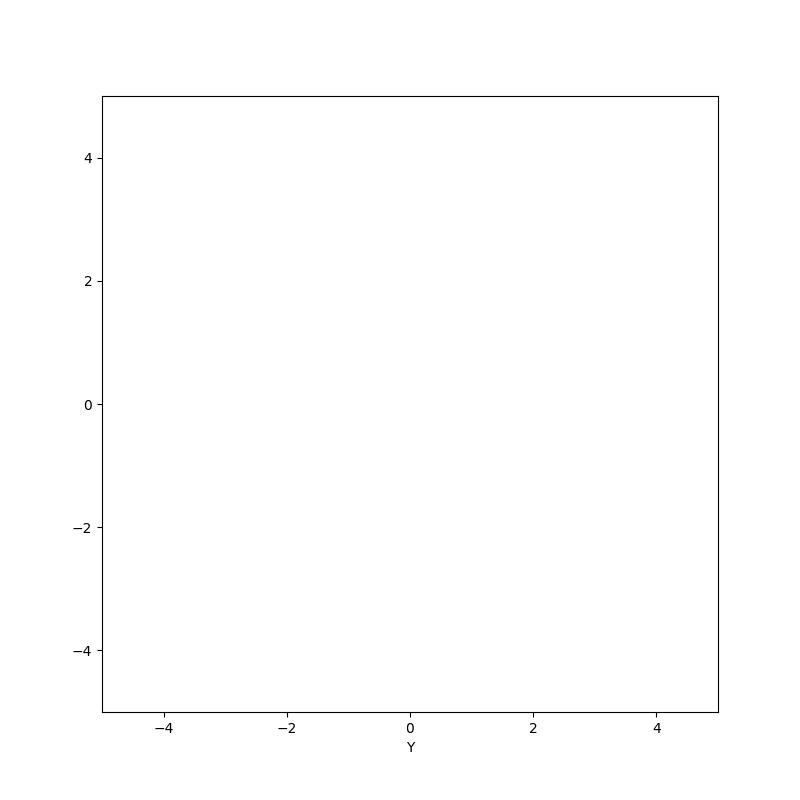

In [5]:
#5.4.1
def trial():
    time_interval=0.1
    world = World(30, time_interval, debug=False)
    
    #地図を生成
    m = Map()
    for ln in [(-4,2),(2,-3),(3,3)]:
        m.append_landmark(Landmark(*ln))
        world.append(m)

    #ロボットを作る
    initial_pose = np.array([0,0,0]).T
    estimator = Mcl(m, initial_pose,100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi,estimator)
    r = Robot(initial_pose, sensor = Camera(m), agent=a, color = "red")
    world.append(r)

    world.draw()
'''
sigma_wv = 0.1
sigma_vv = 0.22
sigma_ww = 0.20
'''
trial()

In [18]:
distance_dev = 0.1
direction_dev = 0.2
pos = np.array([0,0]).T
cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
weight = multivariate_normal(mean=pos, cov=cov).pdf(pos)

In [19]:
weight

np.float64(7.957747154594764)